<a href="https://colab.research.google.com/github/Milad-Abdollahi/PersonalProjects/blob/main/PyTorch_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch FashionMNIST
in this notebook the FashionMNIST dataset will be solved using 2 different NN models. the first model is going be a simple model containing Linear and ReLU layers. and the second model is a Convolutional NN.
link to the dataset: https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

In [17]:
#importing neccesary libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [18]:
# preparing train and test datasets

train_data = datasets.FashionMNIST(root='FashionMNIST_data', train=True, 
                                  transform=ToTensor(), target_transform=None, download=True)


test_data = datasets.FashionMNIST(root='FashionMNIST_data', train=False,
                                  transform=ToTensor(), target_transform=None, download=True)

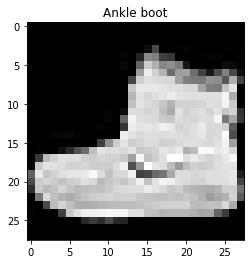

In [19]:
# looking at the shape of first train sample
class_names = train_data.classes # classes in an atribute for the FashionMNIST data
img, label = train_data[0]
plt.imshow(img.squeeze(), cmap='gray');
plt.title(class_names[label]);

In [20]:
from urllib.request import DataHandler
# creating dataloader with batch size 32

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
print(f'number of training batches:{len(train_dataloader)}\nnumber of test batches:{len(test_dataloader)}')

number of training batches:1875
number of test batches:313


In [21]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# first model: Linear NN
the first model is a simple model with 2 linear layers and a ReLU layer in between

In [22]:
# definin a model class

class FashionMNISTLinearNN(nn.Module):
  def __init__(self,input_features:int, hidden_units:int, output_features:int) -> None:
    super().__init__()
    self.sequential = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x:torch.tensor):
    return self.sequential(x)

model_linear = FashionMNISTLinearNN(input_features=28*28, hidden_units=10, output_features=len(class_names))

In [23]:
# sending 1 batch through forward pass
model_linear(train_features_batch).shape# there is no shape issues

torch.Size([32, 10])

In [24]:
# defining loss function and optimizer:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_linear.parameters(), lr=0.05)

In [25]:
# creating a traning loop

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'epoch:{epoch}------')
  model_linear.train()
  for i, (X,y) in enumerate(train_dataloader):
    y_train_linear_logits = model_linear(X)
    loss_linear = loss_fn(y_train_linear_logits, y)
    optimizer.zero_grad()
    loss_linear.backward()
    optimizer.step()
    if i % int(len(train_dataloader)/3) == 0:
      print(f'training loss = {loss_linear}')


  0%|          | 0/3 [00:00<?, ?it/s]

epoch:0------
training loss = 2.3568785190582275
training loss = 0.6880747079849243
training loss = 0.5269869565963745
epoch:1------
training loss = 0.5210378170013428
training loss = 0.46954262256622314
training loss = 0.4360564947128296
epoch:2------
training loss = 0.421122282743454
training loss = 0.2462722212076187
training loss = 0.40395238995552063


In [26]:
linear_model_acc = 0
for X, y in tqdm(test_dataloader):
  y_test_linear_logits = model_linear(X)
  linear_model_acc += accuracy_score(y_true=y, y_pred=torch.softmax(y_test_linear_logits, dim=1).argmax(dim=1))
linear_model_acc /= len(test_dataloader)
f'linear model accuracy = {linear_model_acc:.2%}'

  0%|          | 0/313 [00:00<?, ?it/s]

'linear model accuracy = 83.75%'

# Second model: Convolutional
the second model will be a convolutional NN replicating the architecture of https://poloclub.github.io/cnn-explainer/
because CNNs are usually reccomended for image proccesing problems it is expected that this model will have a higher accuracy versus the first model

In [27]:
class FashionMNIST_CNN(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)        
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )
  
  def forward(self, x:torch.tensor):
    x = self.block1(x)
    # print(x.shape)
    x = self.block2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [28]:
model_cnn = FashionMNIST_CNN(input_shape=1, hidden_units=10, output_shape=len(class_names))
model_cnn

FashionMNIST_CNN(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [29]:
# sending 1 batch through the forward pass
model_cnn(train_features_batch).shape

torch.Size([32, 10])

In [30]:
# defining a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer_cnn = torch.optim.SGD(params=model_cnn.parameters(), lr = 0.05)

In [31]:
# creatin a training loop
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'epoch: {epoch} ------------------')
  model_cnn.train()
  for i, (X, y) in enumerate(train_dataloader):
    y_cnn_train_logits = model_cnn(X)
    loss_cnn = loss_fn(y_cnn_train_logits, y)
    optimizer_cnn.zero_grad()
    loss_cnn.backward()
    optimizer_cnn.step()
    if i % int(len(train_dataloader)/3) == 0:
      print(f'training loss: {loss_cnn}')


  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0 ------------------
training loss: 2.3098344802856445
training loss: 0.51131272315979
training loss: 0.6268194913864136
epoch: 1 ------------------
training loss: 0.6034135222434998
training loss: 0.38029950857162476
training loss: 0.0685059204697609
epoch: 2 ------------------
training loss: 0.357826292514801
training loss: 0.24259406328201294
training loss: 0.4304640293121338


In [37]:
# calcualtin the model accuracy using test data:
cnn_model_acc = 0
for X, y in test_dataloader:
  y_cnn_train_logits = model_cnn(X)
  y_cnn_train_labels = torch.softmax(y_cnn_train_logits, dim=1).argmax(dim=1)
  cnn_model_acc += accuracy_score(y_true=y, y_pred=y_cnn_train_labels)

cnn_model_acc /= len(test_dataloader)
print(f'convolutional model accuracy: {cnn_model_acc:.2%}')

convolutional model accuracy: 87.89%


# evaluating and saving the best model
according to accuracy scores, CNN is the best model to predict FashionMNIST dataset labels
a confusion matrix will be created to for the CNN model to evaluate the performance of the model


In [46]:
# updating and installing libraries
!pip install -U torchmetrics
!pip install -U mlxtend
import torchmetrics
import mlxtend
from torchmetrics import ConfusionMatrix
print(f'mlxtend version: {mlxtend.__version__},\ntorchmetrics version:{torchmetrics.__version__}')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mlxtend version: 0.21.0,
torchmetrics version:0.11.0


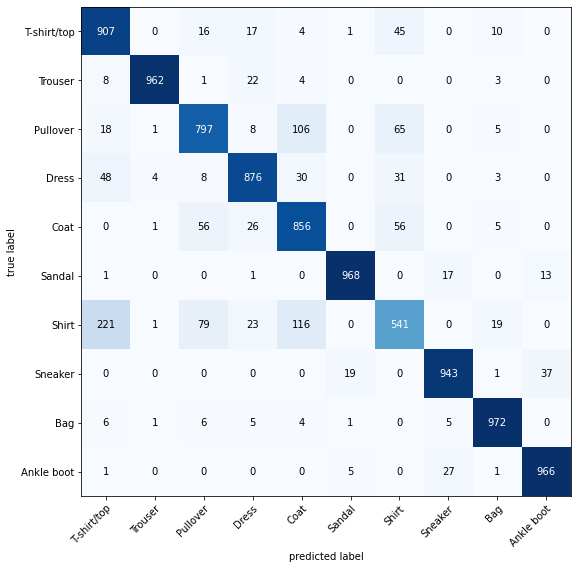

In [51]:
from mlxtend.plotting import plot_confusion_matrix
conf_test_dataloader = DataLoader(test_data, batch_size=10000, shuffle=False)
X_conf, y_conf = next(iter(conf_test_dataloader))
y_conf_logits = model_cnn(X_conf)
y_conf_labels = torch.softmax(y_conf_logits, dim=1).argmax(dim=1)
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_conf_labels, target=test_data.targets)
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(12,9))

In [53]:
# saving the model:
from pathlib import Path
# Creating models directory (if it doesn't already exist)
model_path=Path('models')

model_path.mkdir(parents=True, exist_ok=True)

# Create model save path
# Create model save path
model_name = "FashionMNIST_CNN_Model.pth"
model_save_path = model_path/model_name
print(f'saving model to {model_save_path}')
torch.save(obj=model_cnn.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=model_save_path)

saving model to models/FashionMNIST_CNN_Model.pth


In [55]:
# loading the saved state_dict to a new model
loaded_model_cnn = FashionMNIST_CNN(input_shape=1, hidden_units=10, output_shape=len(class_names))
loaded_model_cnn.load_state_dict(torch.load(f=model_save_path))

<All keys matched successfully>